In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from matplotlib import pyplot as plt, cm

from common import hallmark as hm
from common import viz

In [2]:
pf = hm.ParaFrame('cache/Illinois_thermal_w{win:d}/{mag}a{aspin:g}_i{inc:d}/sed_Rh{Rhigh:d}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

mag ['M' 'S']
aspin [-0.94 -0.5   0.    0.5   0.94]
inc [ 10  30  50  70  90 110 130 150 170]
win [3 4 5]
Rhigh [  1  10  40 160]


In [3]:
colors = ['red', 'darkorange', 'darkgreen', 'darkblue', 'purple']
colors = colors[:0:-1] + colors
styles = ['-'] * 5 + [':'] * 4

magmap = {'M':'MAD', 'S':'SANE'}

def readsed(f, snapshot=None):
    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)
        
    if snapshot is None:
        m = np.mean(avg, axis=0)
        s = np.std (avg, axis=0)
    else:
        m = avg[snapshot,...]
        s = 0
        
    return nu, m, s, [k.decode("utf-8") for k in knd]

def plot_multiscat(ax, pf, snapshot=None):
    for i, p in enumerate(pf.path):
        nu, avg, err, knd = readsed(p, snapshot=snapshot)
        viz.step(ax, nu, avg, label=knd)
    ax.set_xlim(1e9,  1e23)
    ax.set_ylim(1e27, 1e37)
    
def plot_multiinc(ax, pf):
    for i, (_, r) in enumerate(pf.iterrows()):
        nu, avg, err, knd = readsed(r.path)
        viz.step(ax, nu, avg[:,0], linestyle=styles[i], color=colors[i], alpha=0.5, step=False, label=[rf'$i={r.inc}^\circ$'])
    ax.set_xlim(1e9,  1e23)
    ax.set_ylim(1e27, 1e37)
    
def plot_multiwin(ax, pf):
    for i, (_, r) in enumerate(pf.iterrows()):
        nu, avg, err, knd = readsed(r.path)
        viz.step(ax, nu, avg[:,0], color=f'C{i}', step=False, label=[f'win {r.win}'])
    ax.set_xlim(1e9,  1e23)
    ax.set_ylim(1e27, 1e37)

In [4]:
w  = 5
i  = 50
a  = 0.5
Rh = 10

for m in ['M', 'S']:
    for s in range(100):
        print(m, s)
        def plot(*args, **kwargs):
            return plot_multiscat(*args, **kwargs, snapshot=s)
    
        fig = viz.grid(pf(win=w)(mag=m)(inc=i), plot, aspin=[a], Rhigh=[Rh],
                       figsize=(6,6), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$, time $t={s*100+w*10000}M$',
                       xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
                       xlabel=r'Frequency $\nu$ [Hz]',   ylabel=r'$\nu F_\nu$ [erg/s]',
                       legend='upper right',
                       fout=f'output/movie/sedsample_{magmap[m]}_{s:03d}')
        plt.close(fig)

M 0
M 1
M 2
M 3
M 4
M 5
M 6
M 7
M 8
M 9
M 10
M 11
M 12
M 13
M 14
M 15
M 16
M 17
M 18
M 19
M 20
M 21
M 22
M 23
M 24
M 25
M 26
M 27
M 28
M 29
M 30
M 31
M 32
M 33
M 34
M 35
M 36
M 37
M 38
M 39
M 40
M 41
M 42
M 43
M 44
M 45
M 46
M 47
M 48
M 49
M 50
M 51
M 52
M 53
M 54
M 55
M 56
M 57
M 58
M 59
M 60
M 61
M 62
M 63
M 64
M 65
M 66
M 67
M 68
M 69
M 70
M 71
M 72
M 73
M 74
M 75
M 76
M 77
M 78
M 79
M 80
M 81
M 82
M 83
M 84
M 85
M 86
M 87
M 88
M 89
M 90
M 91
M 92
M 93
M 94
M 95
M 96
M 97
M 98
M 99
S 0
S 1
S 2
S 3
S 4
S 5
S 6
S 7
S 8
S 9
S 10
S 11
S 12
S 13
S 14
S 15
S 16
S 17
S 18
S 19
S 20
S 21
S 22
S 23
S 24
S 25
S 26
S 27
S 28
S 29
S 30
S 31
S 32
S 33
S 34
S 35
S 36
S 37
S 38
S 39
S 40
S 41
S 42
S 43
S 44
S 45
S 46
S 47
S 48
S 49
S 50
S 51
S 52
S 53
S 54
S 55
S 56
S 57
S 58
S 59
S 60
S 61
S 62
S 63
S 64
S 65
S 66
S 67
S 68
S 69
S 70
S 71
S 72
S 73
S 74
S 75
S 76
S 77
S 78
S 79
S 80
S 81
S 82
S 83
S 84
S 85
S 86
S 87
S 88
S 89
S 90
S 91
S 92
S 93
S 94
S 95
S 96
S 97
S 98
S 99


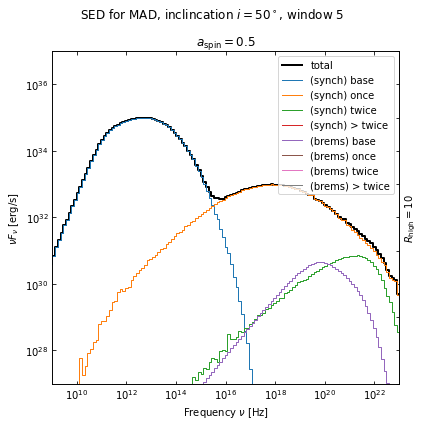

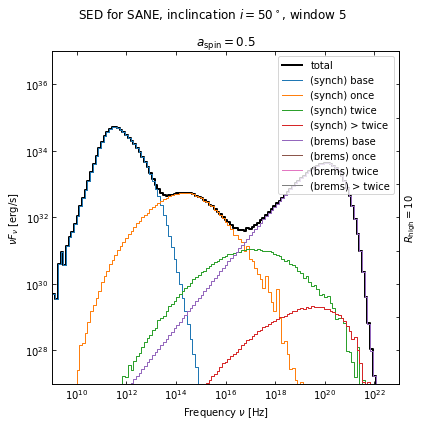

In [5]:
w  = 5
i  = 50
a  = 0.5
Rh = 10

for m in ['M', 'S']:
    fig = viz.grid(pf(win=w)(mag=m)(inc=i), plot_multiscat, aspin=[a], Rhigh=[Rh],
                   figsize=(6,6), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$, window {w}',
                   xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
                   xlabel=r'Frequency $\nu$ [Hz]',   ylabel=r'$\nu F_\nu$ [erg/s]',
                   legend='upper right',
                   fout=f'output/plot/sedsample_{magmap[m]}')

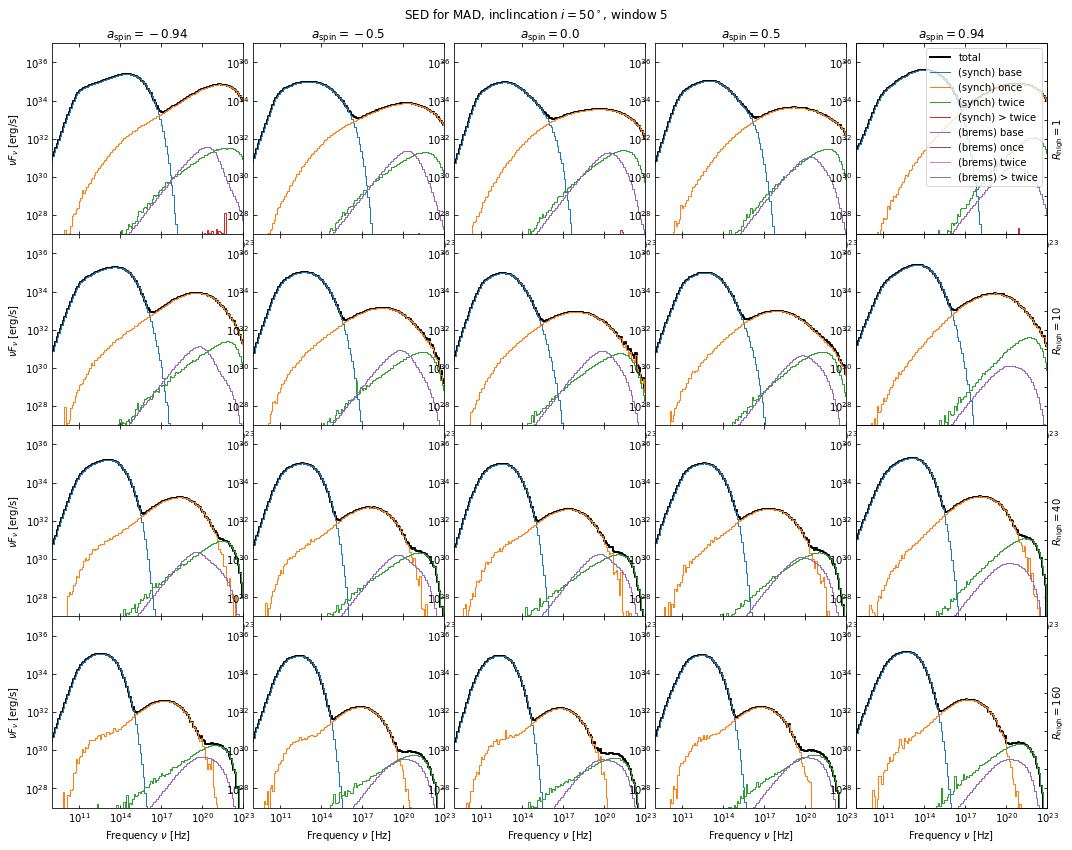

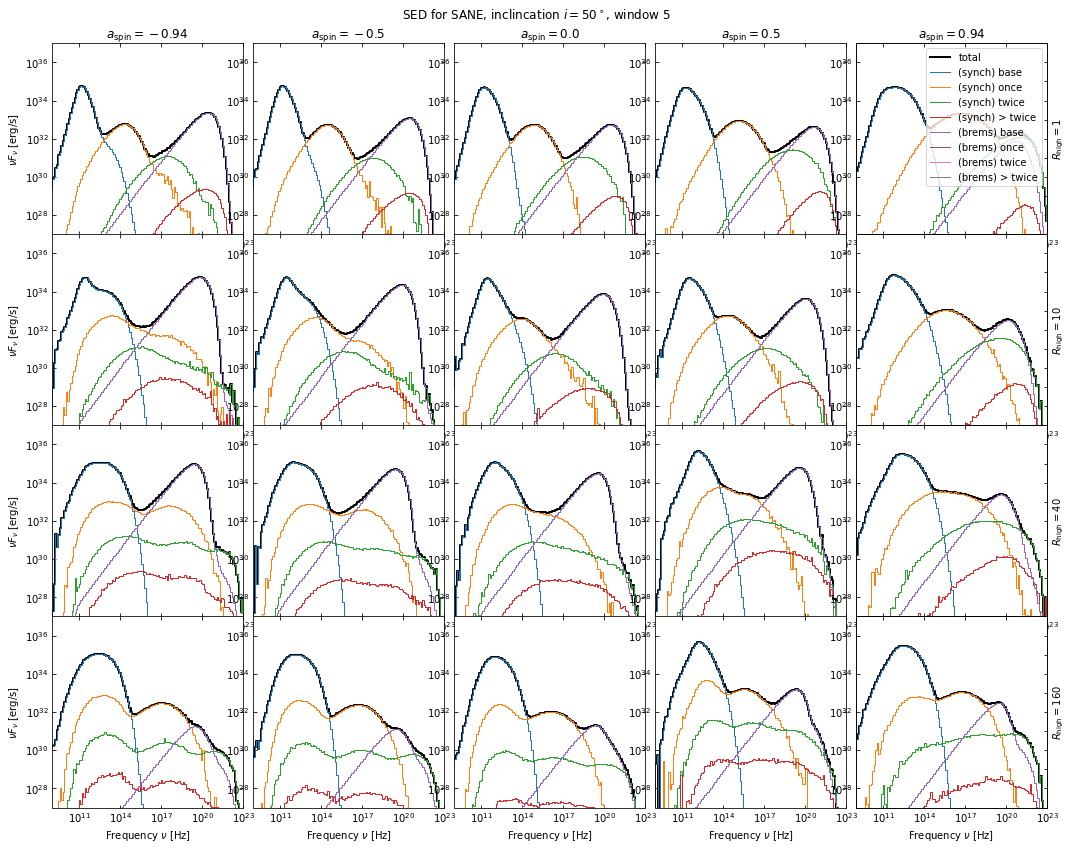

In [6]:
w = 5
i = 50

for m in mag:
    fig = viz.grid(pf(win=w)(mag=m)(inc=i), plot_multiscat, aspin=aspin, Rhigh=Rhigh,
                   figsize=(15,12), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$, window {w}',
                   xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
                   xlabel=r'Frequency $\nu$ [Hz]',   ylabel=r'$\nu F_\nu$ [erg/s]',
                   legend='upper right',
                   fout=f'output/plot/sedscat_{magmap[m]}')

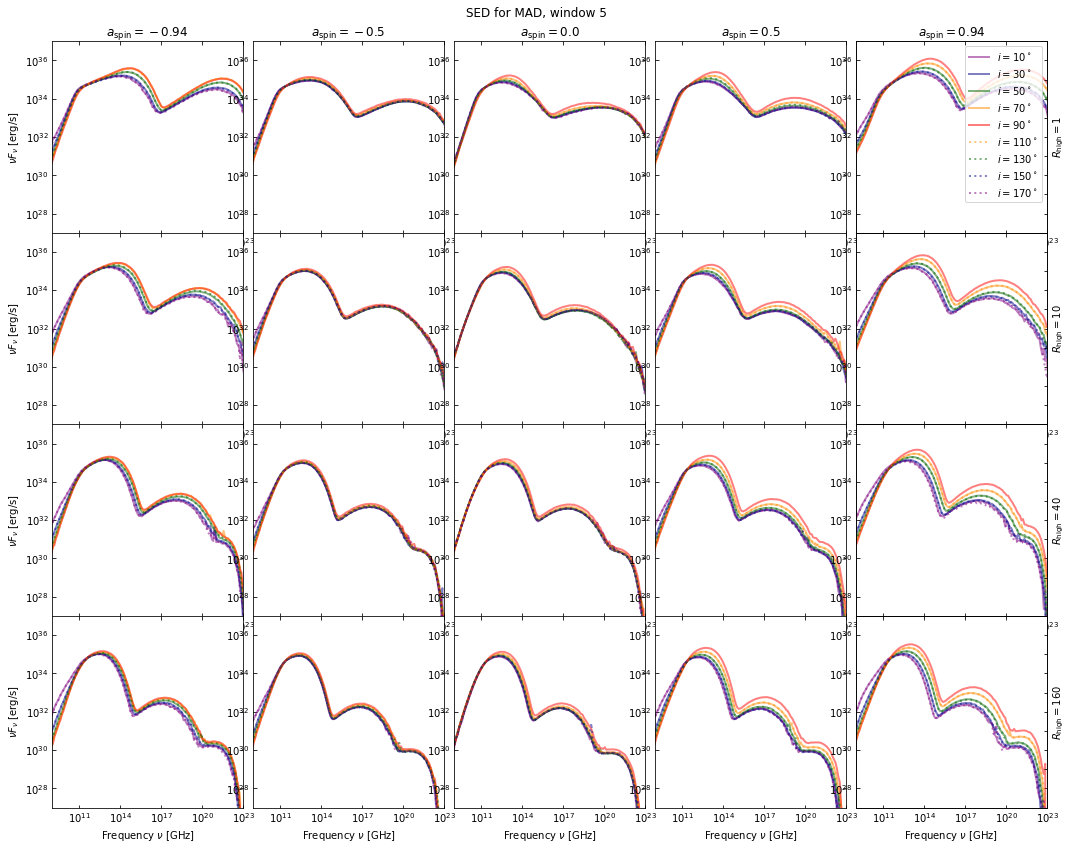

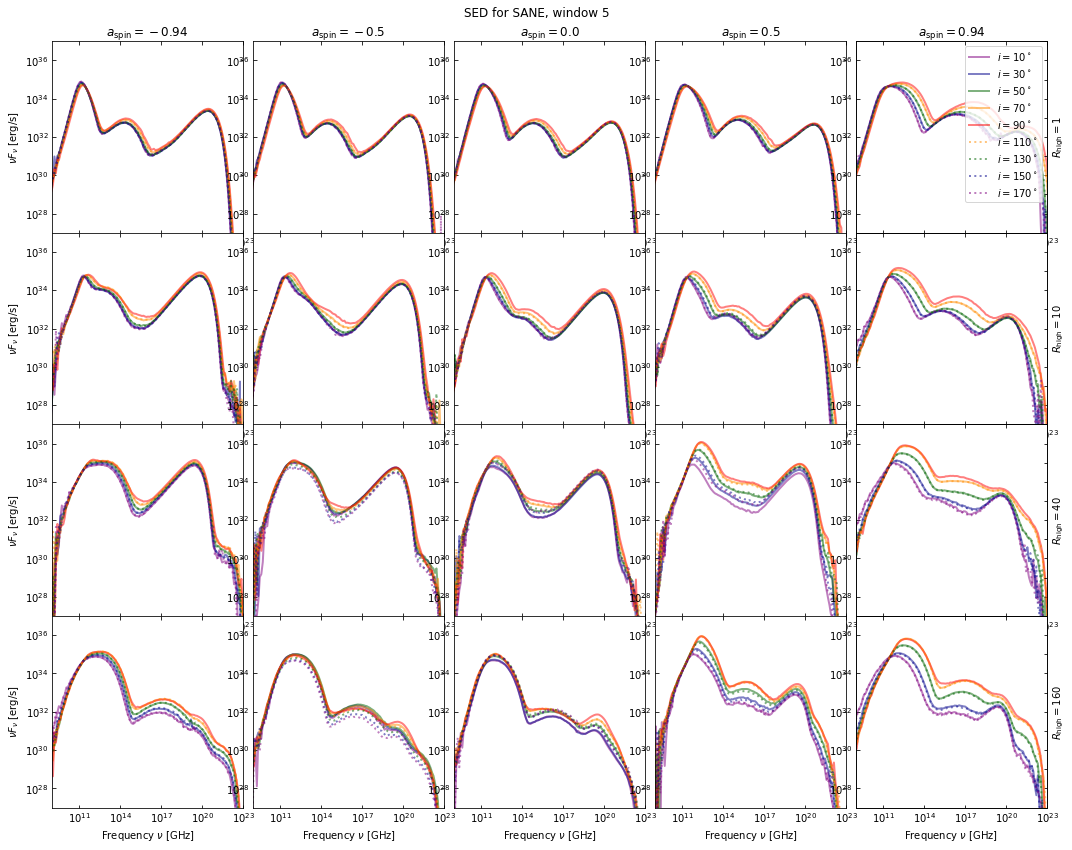

In [7]:
w = 5

for m in mag:
    viz.grid(pf(win=w)(mag=m).sort_values('inc'), plot_multiinc, aspin=aspin, Rhigh=Rhigh,
             figsize=(15,12), title=f'SED for {magmap[m]}, window {w}',
             xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
             xlabel=r'Frequency $\nu$ [GHz]',  ylabel=r'$\nu F_\nu$ [erg/s]',
             legend='upper right',
             fout=f'output/plot/sedinc_{magmap[m]}')

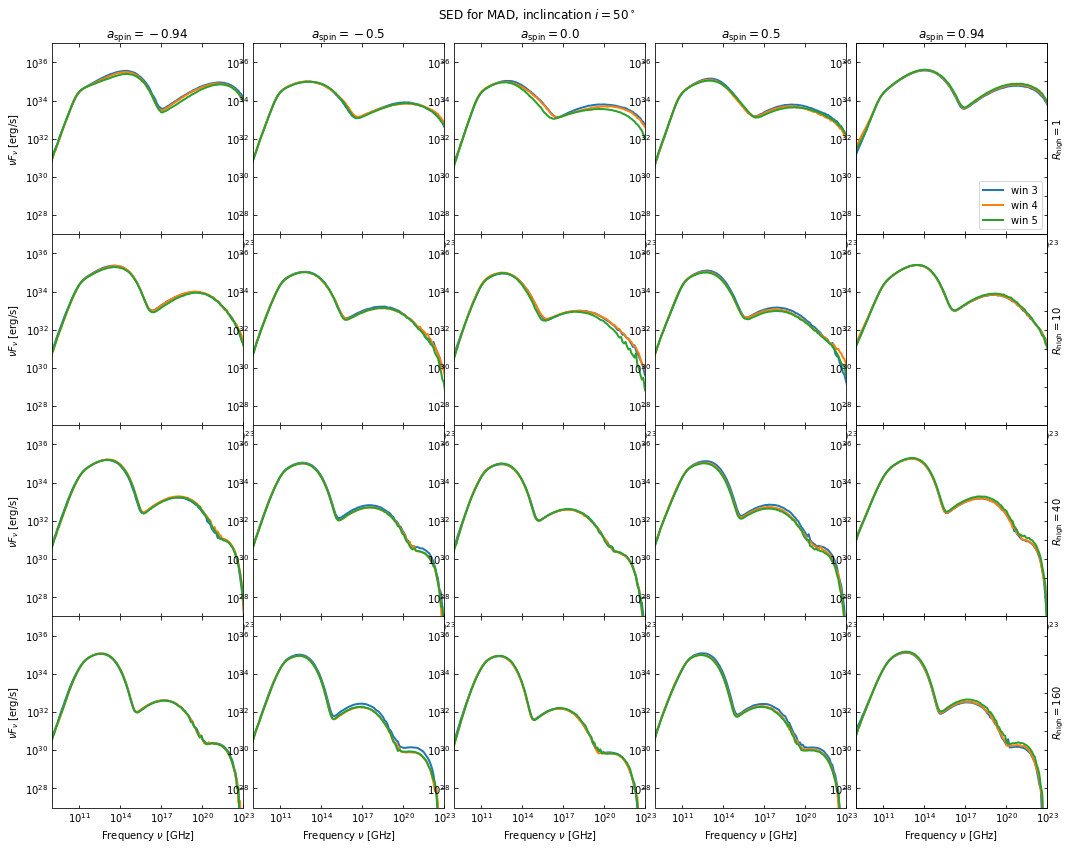

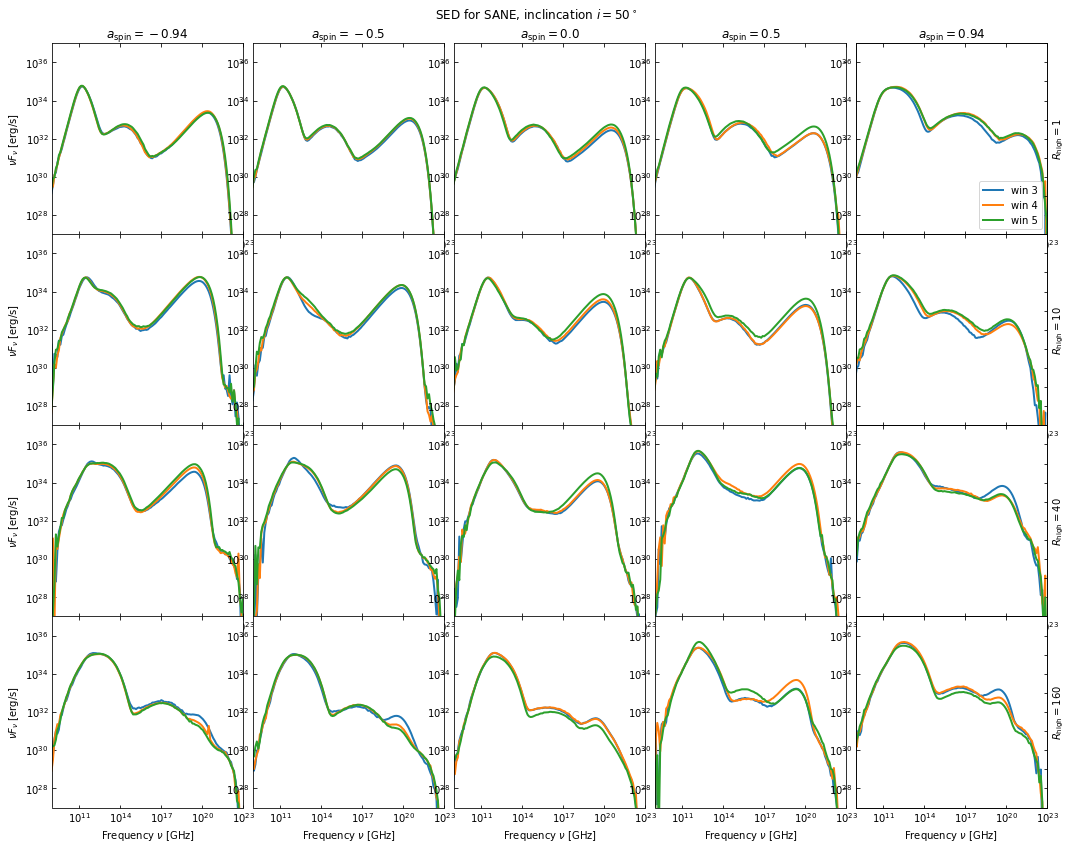

In [8]:
i = 50

for m in mag:
    viz.grid(pf(mag=m)(inc=i).sort_values('win'), plot_multiwin, aspin=aspin, Rhigh=Rhigh,
             figsize=(15,12), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$',
             xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
             xlabel=r'Frequency $\nu$ [GHz]',  ylabel=r'$\nu F_\nu$ [erg/s]',
             legend='lower right',
             fout=f'output/plot/sedwin_{magmap[m]}')